## Import the required libraries

In [5]:
import pandas as pd
import pubchempy as pcp
from tqdm.auto import tqdm
import numpy as np
import itertools
from lib.descriptor_gen import DescriptorGen
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

## Read and preprocess the data

In [6]:
df = pd.read_csv("data/AID_1645841_datatable.csv", skiprows=[1,2,3,4,5], low_memory=False)
df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,5238,90341041,11957637.0,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5238,5239,90341069,4906.0,CCCNC(C)C(=O)NC1=CC=CC=C1C,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5239,5240,90341160,5593.0,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,Active,42,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5240,5241,90341654,2968.0,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,1.3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Drop null values and Convert PUBCHEM_CID to int

In [7]:
df.dropna(subset=["PUBCHEM_CID"], inplace=True)
df.PUBCHEM_CID = df.PUBCHEM_CID.astype(int)
df['Phenotype-Replicate_1'].value_counts(normalize=True)

Phenotype-Replicate_1
Inhibitor    0.580263
Inactive     0.354839
Activator    0.064898
Name: proportion, dtype: float64

## Encode Labels

In [8]:
labels = df['Phenotype-Replicate_1'].unique().tolist()
le = LabelEncoder()
le.fit(labels)
df['label'] = le.transform(df['Phenotype-Replicate_1'])

## Drop the columns that are not required

In [9]:
data_df = df[['PUBCHEM_CID', 'Phenotype-Replicate_1', 'PUBCHEM_EXT_DATASOURCE_SMILES', 'label']]
data_df

,PUBCHEM_CID,Phenotype-Replicate_1,PUBCHEM_EXT_DATASOURCE_SMILES,label
0,197033,Inhibitor,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,2
1,5281670,Inactive,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,1
2,6604832,Inhibitor,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,2
3,5280443,Inhibitor,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,2
4,836,Inhibitor,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,2
...,...,...,...,...
5237,11957637,Inactive,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,1
5238,4906,Inactive,CCCNC(C)C(=O)NC1=CC=CC=C1C,1
5239,5593,Inhibitor,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,2
5240,2968,Inhibitor,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,2


## Generate Descriptors

In [10]:
desc_den = DescriptorGen()
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
data_df.loc[:, 'desc'] = data_df['PUBCHEM_EXT_DATASOURCE_SMILES'].progress_apply(
        desc_den.from_smiles)

100%|██████████| 5239/5239 [00:05<00:00, 884.62it/s] 
/tmp/ipykernel_2024538/1072881647.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:, 'desc'] = data_df['PUBCHEM_EXT_DATASOURCE_SMILES'].progress_apply(


In [11]:
data_df

,PUBCHEM_CID,Phenotype-Replicate_1,PUBCHEM_EXT_DATASOURCE_SMILES,label,desc
0,197033,Inhibitor,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5281670,Inactive,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6604832,Inhibitor,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,2,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,5280443,Inhibitor,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,836,Inhibitor,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
5237,11957637,Inactive,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5238,4906,Inactive,CCCNC(C)C(=O)NC1=CC=CC=C1C,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5239,5593,Inhibitor,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5240,2968,Inhibitor,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Test Train Split

In [12]:
train, test = train_test_split(data_df, test_size=0.2)
train_X = np.stack(train.desc)
train_y = train.label
test_X = np.stack(test.desc)
test_y = test.label

## Create and train a model

In [13]:
lgbm = LGBMClassifier()
lgbm.fit(train_X, train_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9274
[LightGBM] [Info] Number of data points in the train set: 4191, number of used features: 1682
[LightGBM] [Info] Start training from score -2.713074
[LightGBM] [Info] Start training from score -1.049038
[LightGBM] [Info] Start training from score -0.538894


LGBMClassifier()

## Calculate ROC AUC Score

In [14]:
pred = lgbm.predict_proba(test_X)
roc_auc_score(test_y,pred,multi_class='ovo',average='macro')


0.7408657844789595

## Compensate for class imbalance

In [15]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()
resampled_X, resampled_y = oversampler.fit_resample(train_X, train_y)

In [16]:
resampled_lgbm = LGBMClassifier()
resampled_lgbm.fit(resampled_X, resampled_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9787
[LightGBM] [Info] Number of data points in the train set: 7335, number of used features: 1935
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier()

## Calculate new ROC AUC Score

In [17]:
resampled_pred = resampled_lgbm.predict_proba(test_X)
roc_auc_score(test_y,resampled_pred,multi_class='ovo',average='macro')

0.7299678752781534

## Compare the Confusion Matrices

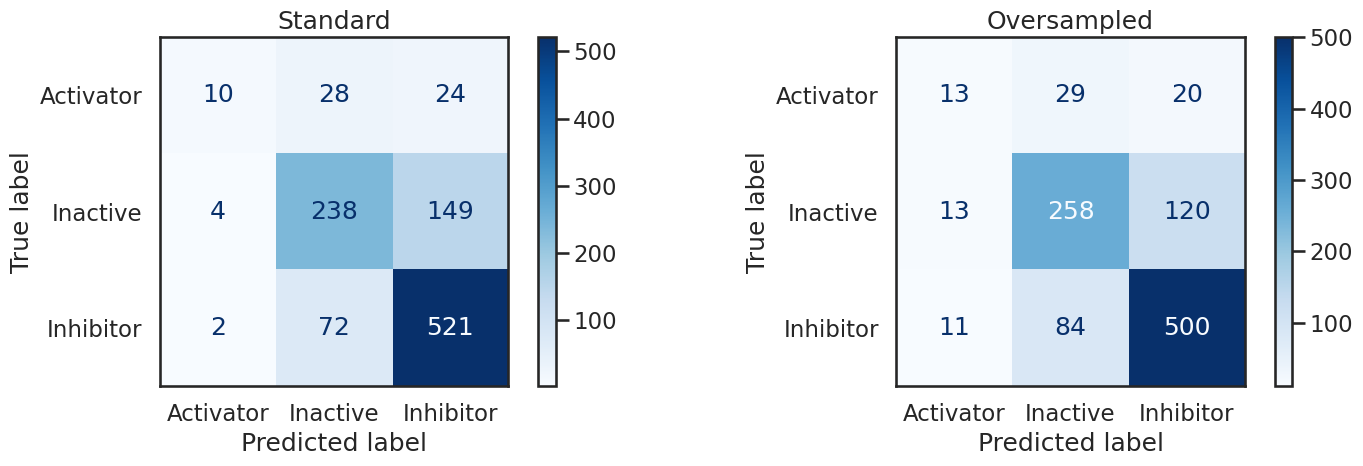

In [18]:
sns.set_style("white")
sns.set_context('talk')
classifiers = [lgbm,resampled_lgbm]
titles = ["Standard","Oversampled"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for cls,ax,title in zip(classifiers, axes, titles):
    disp = ConfusionMatrixDisplay.from_estimator(cls, test_X, test_y, display_labels=sorted(labels), cmap=plt.cm.Blues, ax=ax)
    disp.ax_.set_title(title)
plt.tight_layout()

## Run 10 rounds of cross-validation

In [19]:
res = []
for i in tqdm(range(0,10)):
    # split the data into training and test sets
    train, test = train_test_split(data_df)
    train_X = np.stack(train.desc)
    train_y = train.label
    test_X = np.stack(test.desc)
    test_y = test.label
    # Create the standard model
    lgbm = LGBMClassifier()
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict_proba(test_X)
    auc = roc_auc_score(test_y,pred,multi_class='ovo',average='macro')
    # Create the resampled model
    resampled_lgbm = LGBMClassifier()
    resampled_X, resampled_y = oversampler.fit_resample(train_X,train_y)
    resampled_lgbm.fit(resampled_X, resampled_y)
    resampled_pred = resampled_lgbm.predict_proba(test_X)
    resampled_auc = roc_auc_score(test_y,resampled_pred,multi_class='ovr',average='macro')
    res.append([auc, resampled_auc])

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9207
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1646
[LightGBM] [Info] Start training from score -2.762711
[LightGBM] [Info] Start training from score -1.037643
[LightGBM] [Info] Start training from score -0.540270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9703
[LightGBM] [Info] Number of data points in the train set: 6867, number of used features: 1887
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 10%|█         | 1/10 [00:01<00:13,  1.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9172
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1634
[LightGBM] [Info] Start training from score -2.727064
[LightGBM] [Info] Start training from score -1.034774
[LightGBM] [Info] Start training from score -0.545965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9697
[LightGBM] [Info] Number of data points in the train set: 6828, number of used features: 1898
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 20%|██        | 2/10 [00:02<00:11,  1.41s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9200
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1641
[LightGBM] [Info] Start training from score -2.746711
[LightGBM] [Info] Start training from score -1.036208
[LightGBM] [Info] Start training from score -0.542895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9717
[LightGBM] [Info] Number of data points in the train set: 6849, number of used features: 1893
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 30%|███       | 3/10 [00:04<00:10,  1.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9154
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1623
[LightGBM] [Info] Start training from score -2.696410
[LightGBM] [Info] Start training from score -1.047026
[LightGBM] [Info] Start training from score -0.542019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9721
[LightGBM] [Info] Number of data points in the train set: 6855, number of used features: 1905
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 40%|████      | 4/10 [00:06<00:09,  1.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9212
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1649
[LightGBM] [Info] Start training from score -2.696410
[LightGBM] [Info] Start training from score -1.037643
[LightGBM] [Info] Start training from score -0.547724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9731
[LightGBM] [Info] Number of data points in the train set: 6816, number of used features: 1904
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 50%|█████     | 5/10 [00:07<00:08,  1.64s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9152
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1623
[LightGBM] [Info] Start training from score -2.778972
[LightGBM] [Info] Start training from score -1.007917
[LightGBM] [Info] Start training from score -0.557010
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9675
[LightGBM] [Info] Number of data points in the train set: 6753, number of used features: 1887
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9171
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1636
[LightGBM] [Info] Start training from score -2.692644
[LightGBM] [Info] Start training from score -1.026215
[LightGBM] [Info] Start training from score -0.555235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9685
[LightGBM] [Info] Number of data points in the train set: 6765, number of used features: 1890
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 70%|███████   | 7/10 [00:11<00:04,  1.60s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9156
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1623
[LightGBM] [Info] Start training from score -2.754679
[LightGBM] [Info] Start training from score -1.021255
[LightGBM] [Info] Start training from score -0.551252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9744
[LightGBM] [Info] Number of data points in the train set: 6792, number of used features: 1907
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 80%|████████  | 8/10 [00:12<00:03,  1.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9163
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1624
[LightGBM] [Info] Start training from score -2.734877
[LightGBM] [Info] Start training from score -1.036208
[LightGBM] [Info] Start training from score -0.544209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9694
[LightGBM] [Info] Number of data points in the train set: 6840, number of used features: 1891
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9152
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1620
[LightGBM] [Info] Start training from score -2.770809
[LightGBM] [Info] Start training from score -1.024086
[LightGBM] [Info] Start training from score -0.547724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9717
[LightGBM] [Info] Number of data points in the train set: 6816, number of used features: 1903
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


## Plot AUC distributions for the Standard and Oversampled Models

In [20]:
res = np.array(res)
res_df = pd.DataFrame(res,columns=["Standard","Oversampled"])
melt_df = res_df.melt()
melt_df.columns = ["Method","AUC"]

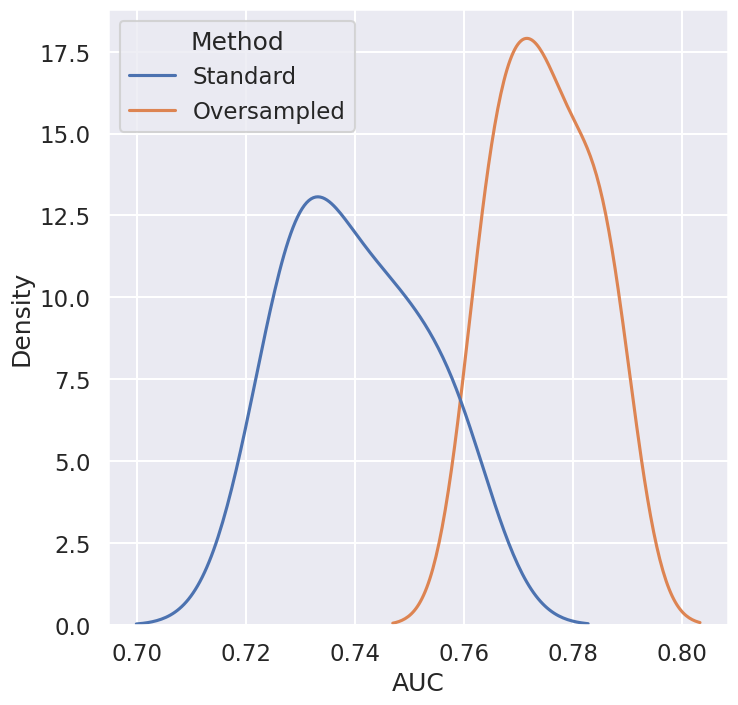

In [21]:
sns.set(rc={'figure.figsize': (8, 8)})
sns.set_context('talk')
sns.kdeplot(x="AUC",hue="Method",data=melt_df);

## Boxplot of AUC distributions

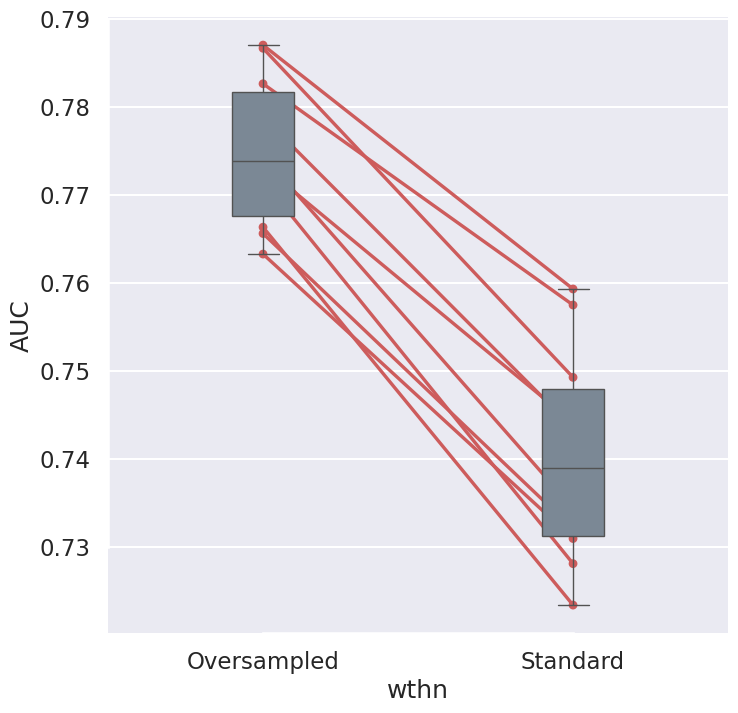

In [22]:
from pingouin import wilcoxon, plot_paired
melt_df['cycle'] = list(range(0,10))+list(range(0,10))
plot_paired(data=melt_df,dv="AUC",within="Method",subject="cycle");

## Import Exported model and predict on test data

In [27]:
import pickle
model = None
with open("data/model.pkl","rb") as f:
    model = pickle.load(f)

In [28]:
pred0 = resampled_lgbm.predict_proba(test_X)
pred1 = model.predict_proba(test_X)

In [29]:
print(roc_auc_score(test_y,pred0,multi_class='ovo',average='macro'))
print(roc_auc_score(test_y,pred1,multi_class='ovo',average='macro'))

0.7518788562840362
0.9946383367072725


ROC AUC is around 0.99 which indicates the exported model is working as expected. This is not the true ROC AUC score as the model is trained and tested on the same data, but it is a good indicator that the model is working as expected.